# Stabilisation
Ce script a pour but de stabiliser les photos, c'est à dire de mapper des points d'intérêts entre deux photos quasi identiques mais prises avec des angles un peu différents.
Ce processus a pour but d'augmenter la performance du réseau de neurones en appliquant cette transformation à toute photo en entrée du réseau.

##### Importation des librairies

In [1]:
import os
import cv2
import numpy as np
from random import choice
import matplotlib.pyplot as plt

##### Lecture des données

In [2]:
# Chemin vers les données
PATH_IMG = "/home/erwan/Centrale/OSY/DEEPL/Projet/QueueDetection/data/img/"
IMG_SIZE = 256

# la photo référence correspond à une photo du lieu de la queue sans personnes
photo_ref = "53921567_2296448580598357_4772525796268965888_n.jpg"

In [3]:
def load_random(path_img, img_size=256, img_ref_name=""):
    """
    Charge aléatoirement une image contenue dans le répertoires 'path_img'
    - img_size : change la taille de l'image
    """
    # random selection of one image
    while True:
        file = choice(os.listdir(path_img))
        if not os.path.isfile(os.path.join(path_img, file)) or file == img_ref_name:
            continue
        else:
            break
    
    img = cv2.imread(os.path.join(path_img, file), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size)).astype(np.float32)
    return img

In [4]:
def load_img(path_img, photo_ref, img_size=256):
    """
    Charge l'image de référence ainsi qu'une autre image aléatoire
    """
    # Lecture de l'image de référence
    img_ref = cv2.imread(os.path.join(path_img, photo_ref), cv2.IMREAD_COLOR)
    img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB)
    img_ref = cv2.resize(img_ref, (IMG_SIZE, IMG_SIZE)).astype(np.float32)

    # Lecture d'une image aléatoire
    img = load_random(path_img, img_size=img_size, img_ref_name=photo_ref)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_ref.astype(np.uint8), interpolation='nearest')
    plt.title('image de référence')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img.astype(np.uint8), interpolation='nearest')
    plt.title('image aléatoire')
    plt.axis('off')
    plt.show()
    return img_ref, img

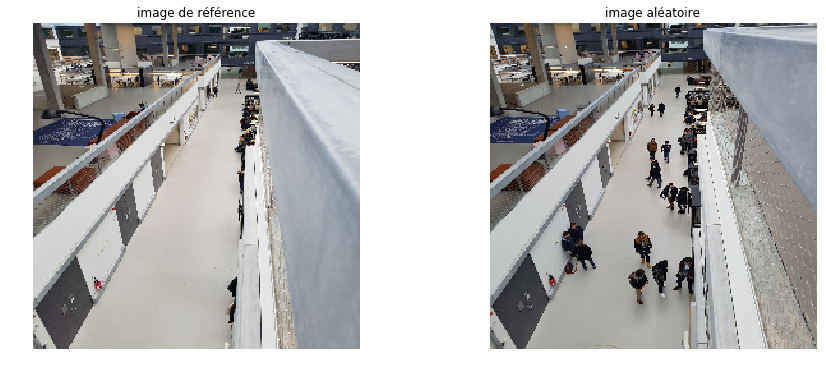

In [5]:
img_ref, img = load_img(PATH_IMG, photo_ref, img_size=IMG_SIZE)

In [6]:
def get_interest_point(img, display=False):
    """
    Renvoie les points d'intérêts d'une image
    """
    features = cv2.goodFeaturesToTrack(img, maxCorners=100, qualityLevel=0.01, minDistance=20)
    
    x = list()
    y = list()
    for interest in features:
        x.append(interest[0][0])
        y.append(interest[0][1])

    if display:
        plt.figure(figsize=(15, 6))
        plt.imshow(img.astype(np.uint8))
        plt.scatter(x, y, c='b')
        plt.axis('off')
        plt.title("points d'intérêts de la photo")
        plt.show()
    return x, y

In [7]:
# convert 2 gray
img_ref_gray = cv2.cvtColor(img_ref, cv2.COLOR_RGB2GRAY)
img_ref_gray = img_ref_gray.astype(np.uint8)
# find features
prev_pts = cv2.goodFeaturesToTrack(img_ref_gray, 200, 0.01, 30)

In [8]:
# convert 2 gray
img_gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
img_gray = img_gray.astype(np.uint8)
# find transformation
curr_pts, status, err = cv2.calcOpticalFlowPyrLK(img_ref_gray, img_gray, prev_pts, None)

In [9]:
# Filter only valid points
idx = np.where(status==1)[0]
prev_pts = prev_pts[idx]
curr_pts = curr_pts[idx]

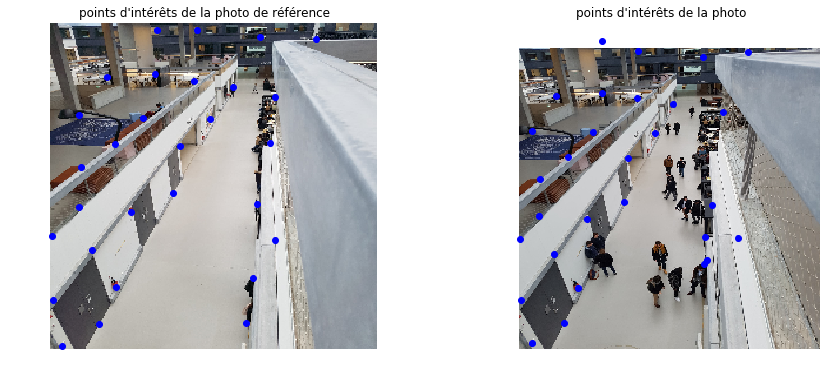

In [12]:
x = list()
y = list()
for interest in prev_pts:
    x.append(interest[0][0])
    y.append(interest[0][1])

if display:
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_ref.astype(np.uint8))
    plt.scatter(x, y, c='b')
    plt.axis('off')
    plt.title("points d'intérêts de la photo de référence")
    
x = list()
y = list()
for interest in curr_pts:
    x.append(interest[0][0])
    y.append(interest[0][1])

if display:
    plt.subplot(1, 2, 2)
    plt.imshow(img.astype(np.uint8))
    plt.scatter(x, y, c='b')
    plt.axis('off')
    plt.title("points d'intérêts de la photo")
    plt.show()

In [14]:
# Estimation de la transformation entre les anciens et les nouveaux points d'intérêts
transform = cv2.estimateAffine2D(prev_pts, curr_pts, False)

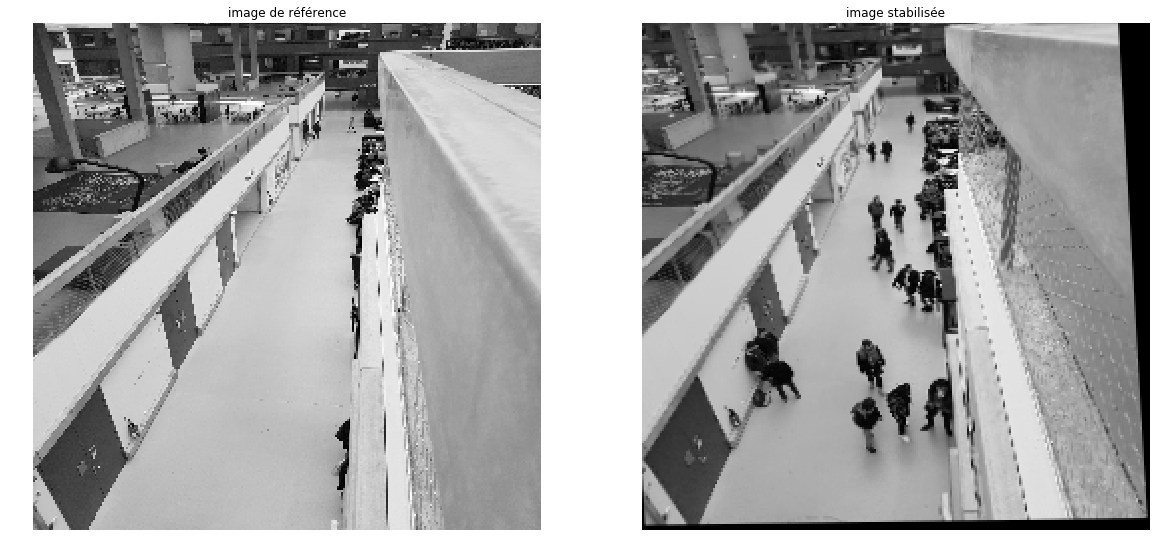

In [16]:
# Transformation Affine de la photo
test = cv2.warpAffine(img_gray, transform[0], dsize=(256, 256))
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_ref, cv2.COLOR_RGB2GRAY).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.title('image de référence')
plt.subplot(1, 2, 2)
plt.imshow(test, cmap='gray')
plt.axis('off')
plt.title('image stabilisée')
plt.show()